In [1]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.set_option("display.max_columns", None) 


from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_roc_curve, classification_report

In [2]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

In [3]:
df = pd.read_csv(r"./data/bank_data.csv", index_col=[0])
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
df.shape

(10127, 21)

In [5]:
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [6]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [7]:
df['Churn'] = df['Attrition_Flag'].apply(lambda val: 0 if val == "Existing Customer" else 1)


In [8]:
def perform_eda(df):
    size = {"fontsize" :15}
    
    plt.figure(figsize=(8,8)) 
    df.Churn.value_counts('normalize').plot(kind='bar')
    plt.title("Percentage of churning", fontdict = size);
    
    plt.figure(figsize=(8,8))  
    df['Customer_Age'].hist()
    plt.title("Age distribution", fontdict = size);
    
    plt.figure(figsize=(8,8))  
    df.Marital_Status.value_counts('normalize').plot(kind='bar')
    plt.title("Percentage of Marital status", fontdict = size);
    
    plt.figure(figsize=(8,8)) 
    sns.distplot(df['Total_Trans_Ct'], kde=False)
    plt.title("Distribution of Total_Trans_Ct", fontdict = size);
    
    plt.figure(figsize=(8,8)) 
    sns.heatmap(df.corr(), annot=False, cmap='Dark2_r', linewidths = 2)
    plt.title("Correlation matrice", fontdict = size);

    
    

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


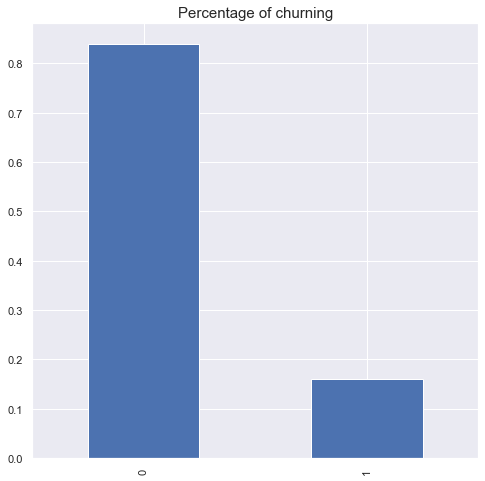

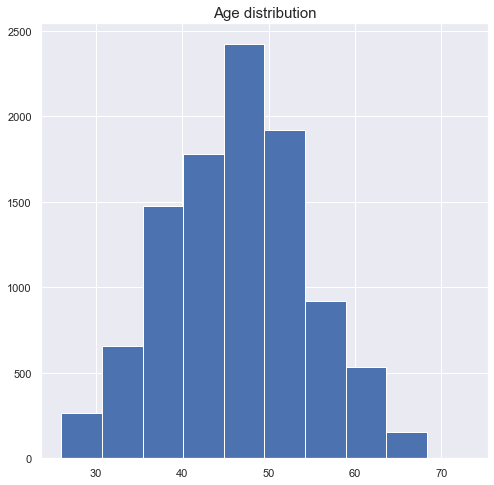

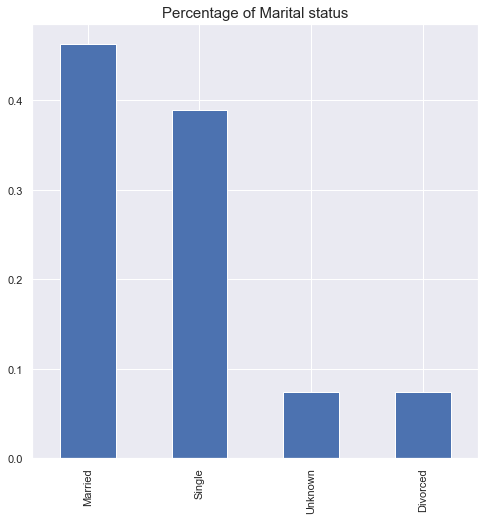

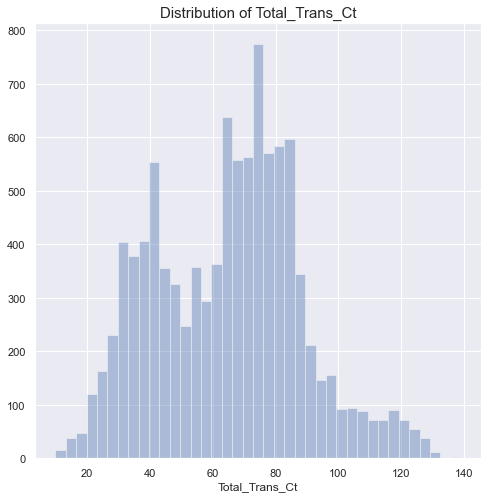

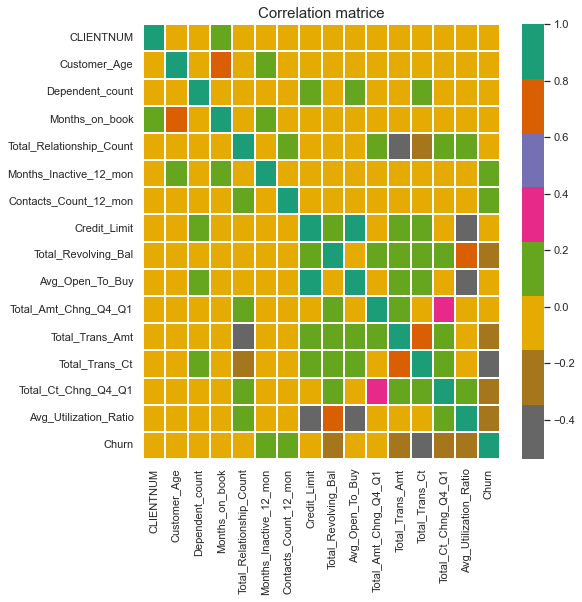

In [9]:
perform_eda(df)

In [10]:
#selection of categorical variables of the dataset
cat_columns = df.select_dtypes(["object"]).columns
cat_columns

Index(['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category'],
      dtype='object')

In [11]:
#Encoding the variables with mean of the target Churn
def encoding_catvar(df, variable):
    var_mean = df.groupby(variable).mean()['Churn']
    var_mean_mapping_mean = var_mean.to_dict()
    df[variable] = df[variable].map(var_mean_mapping_mean)
    return df

In [12]:
for variable in cat_columns:
    encoding_catvar(df, variable)

In [22]:
# We separate the features and the target
X = df.drop(["Attrition_Flag", "CLIENTNUM", "Churn"], axis = 1)
y = df["Churn"]

In [23]:
# This cell may take up to 15-20 minutes to run
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)


In [24]:
# grid search
random_forest = RandomForestClassifier(random_state=42)
# Use a different solver if the default 'lbfgs' fails to converge
param_grid = { 'max_depth' : [4,5,10]}
cv_random_forest = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)


In [25]:
cv_random_forest.fit(X_train, y_train)

y_train_preds_random_forest = cv_random_forest.best_estimator_.predict(X_train)
y_test_preds_random_forest = cv_random_forest.best_estimator_.predict(X_test)

In [26]:
# scores
print('random forest results')
print('test results')
print(classification_report(y_test, y_test_preds_random_forest))
print('train results')
print(classification_report(y_train, y_train_preds_random_forest))

random forest results
test results
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2543
           1       0.93      0.75      0.83       496

    accuracy                           0.95      3039
   macro avg       0.94      0.87      0.90      3039
weighted avg       0.95      0.95      0.95      3039

train results
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5957
           1       0.99      0.92      0.96      1131

    accuracy                           0.99      7088
   macro avg       0.99      0.96      0.97      7088
weighted avg       0.99      0.99      0.99      7088



In [27]:
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=3000)
logistic_regression.fit(X_train, y_train)
y_train_preds_lr = logistic_regression.predict(X_train)
y_test_preds_lr = logistic_regression.predict(X_test)

print('logistic regression results')
print('test results')
print(classification_report(y_test, y_test_preds_lr))
print('train results')
print(classification_report(y_train, y_train_preds_lr))

logistic regression results
test results
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2543
           1       0.72      0.44      0.54       496

    accuracy                           0.88      3039
   macro avg       0.81      0.70      0.74      3039
weighted avg       0.87      0.88      0.87      3039

train results
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      5957
           1       0.73      0.50      0.59      1131

    accuracy                           0.89      7088
   macro avg       0.82      0.73      0.76      7088
weighted avg       0.88      0.89      0.88      7088



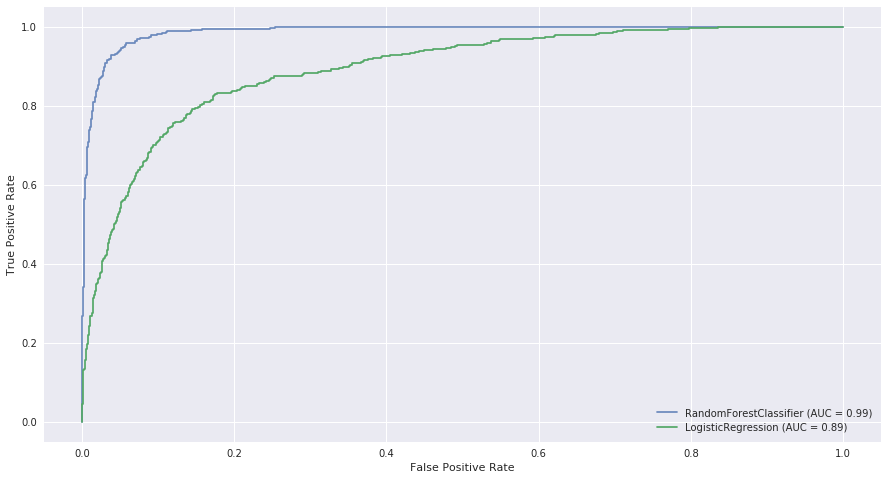

In [28]:
# plots the AUC of the 2 models
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(cv_random_forest.best_estimator_, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot = plot_roc_curve(logistic_regression, X_test, y_test, ax = ax)
plt.show()

In [29]:
# save best model
joblib.dump(cv_random_forest.best_estimator_, './models/randomForest_model.pkl')
joblib.dump(logistic_regression, './models/logistic_model.pkl')

['./models/logistic_model.pkl']

In [30]:
RandomForest_model = joblib.load('./models/randomForest_model.pkl')
LogisticRegression_model = joblib.load('./models/logistic_model.pkl')

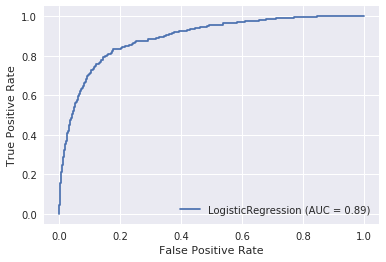

In [31]:
lrc_plot = plot_roc_curve(LogisticRegression_model, X_test, y_test)

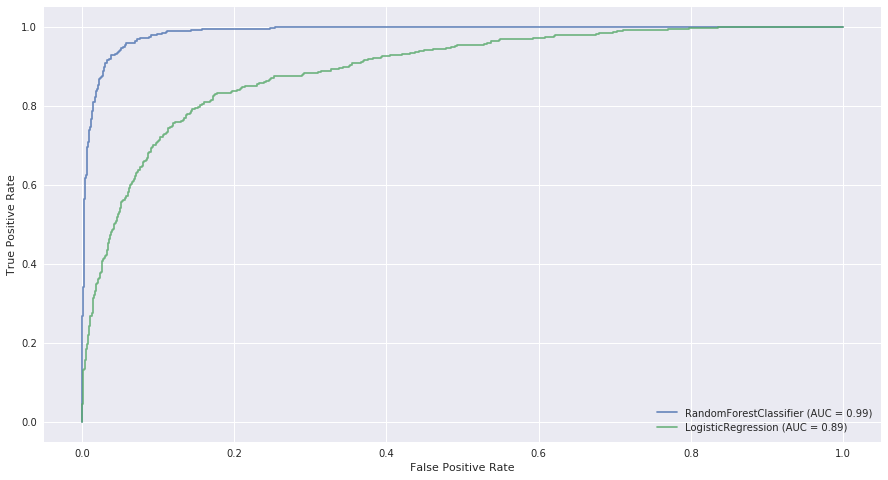

In [32]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
rfc_disp = plot_roc_curve(RandomForest_model, X_test, y_test, ax=ax, alpha=0.8)
lrc_plot.plot(ax=ax, alpha=0.8)
plt.show()

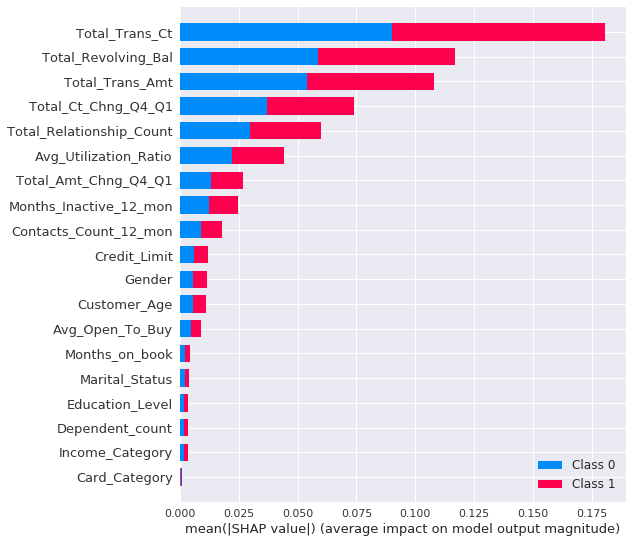

In [33]:
explainer = shap.TreeExplainer(cv_random_forest.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

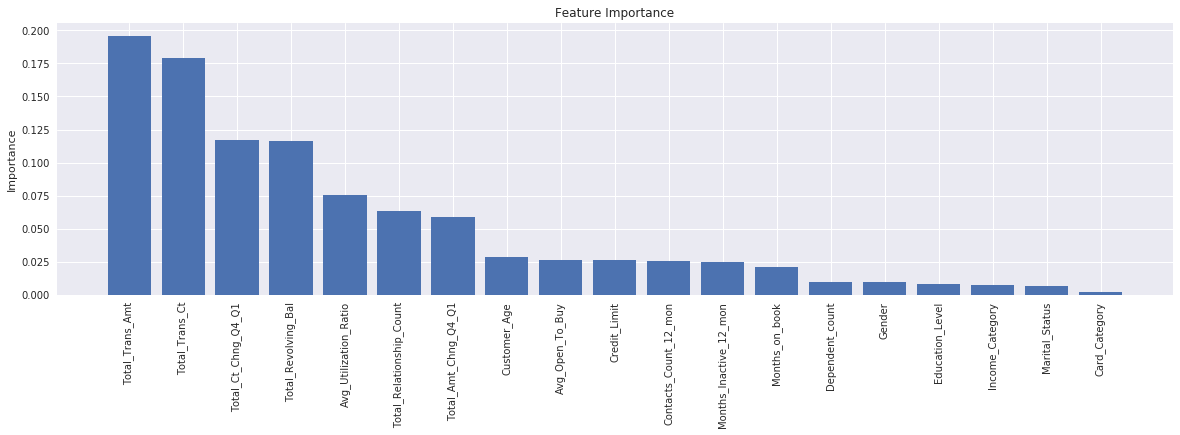

In [42]:
# Calculate feature importances
importances = RandomForest_model.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(20,5))

# Create plot title
plt.title("Feature Importance")
plt.ylabel('Importance')

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90);

In [39]:
def report():
    
    plt.figure(figsize=(5, 5))
    plt.text(0.01, 1.25, str('Random Forest Train'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.05, str(classification_report(y_test, y_test_preds_random_forest)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.text(0.01, 0.6, str('Random Forest Test'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.7, str(classification_report(y_train, y_train_preds_random_forest)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off');
    
    plt.figure(figsize=(5, 5))
    plt.text(0.01, 1.25, str('Logistic Regression Train'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.05, str(classification_report(y_train, y_train_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.text(0.01, 0.6, str('Logistic Regression Test'), {'fontsize': 10}, fontproperties = 'monospace')
    plt.text(0.01, 0.7, str(classification_report(y_test, y_test_preds_lr)), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
    plt.axis('off');


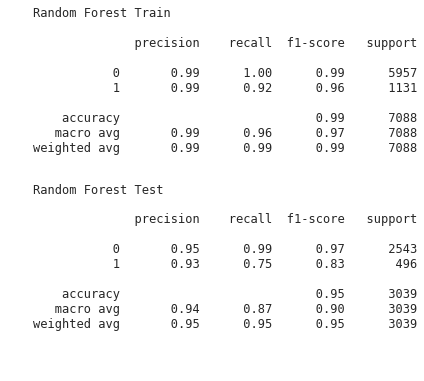

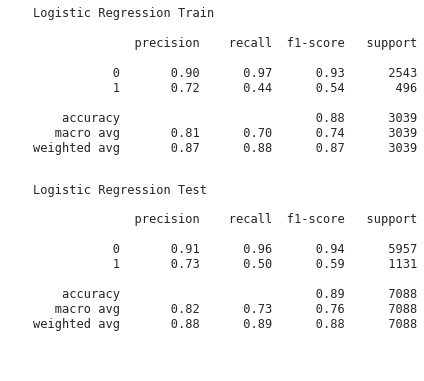

In [40]:
report()